# The Problem: Discrimination by Proxy

In [1]:
import json
from DiscriminationMitigation import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # turn off tensorflow warning messages

In [2]:
# Function to create a Tensorflow Keras deep learning model
def keras_model():
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(16))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to aggregate a dataframe according to a rounded feature, 'w0'
def aggregate_data(df):
    df = pd.concat([df, synth[['w0']].reset_index(drop=True)], axis=1)
    df['w0'] = round(df['w0'], 1)
    df = df.sort_values(by=['w0'])
    return df.groupby(['w0']).mean()

### Instantiate synthetic data

In [3]:
def simple_synth(n=8000, class_prob=0.5, gamma=np.matrix([[2,3.5],[.4,.6]]), alpha=np.matrix([[0,2]]), 
                 beta=np.matrix([[2,2],[1,1]])):
    
    np.random.seed(1776)

    # Protected class variable
    c1 = np.random.binomial(1, p=class_prob, size=n) # group 1
    c0 = 1-c1 # group 0

    # Other covariates
    w0 = gamma[0,0]*c0 + gamma[0,1]*c1 + np.random.normal(0, 0.5, size=n) # linear function of class & shock
    w1 = gamma[1,0]*c0 + gamma[1,1]*c1 + np.random.normal(0, 0.3, size=n)
                                                                 
    # Outcome variable
    y = alpha[0,0]*c0 + alpha[0,1]*c1 + beta[0,0]*c0*w0 + beta[0,1]*c1*w0 + beta[1,0]*c0*w1 + beta[1,1]*c1*w1 + \
        np.random.normal(0, 0.3, size=n)

    return pd.DataFrame([y, c0, c1, w0, w1]).T.rename(columns={0:'y', 1: 'c0', 2: 'c1', 3: 'w0', 4:'w1'})

In [4]:
synth = simple_synth()
print(synth.head())
print("\n", synth.shape)

          y   c0   c1        w0        w1
0  4.673528  1.0  0.0  2.214135  0.324108
1  7.939870  0.0  1.0  2.404301  1.070192
2  5.222822  1.0  0.0  2.338783  0.519127
3  9.406248  0.0  1.0  3.145858  0.822292
4  3.990423  1.0  0.0  1.523643  0.897265

 (8000, 5)


To illustrate the problem of discrimination by proxy, we synthesize data with a continuous target variable *y*, a binary protected class feature with two dummies for category *c1* and *c0*, and covariates *w1* and *w2*, which are linear functions of class membership and random noise. The target variables *y* is determined by covariates, independent normal draws, and class category membership. Class category differences in *y* can be thought of many ways. We find it most convenient to interpret it as representing unobserved causal variables that are correlated with protected class, but it could also represent statistical discrimination or taste-based discrimination.

### Visualizing the problem

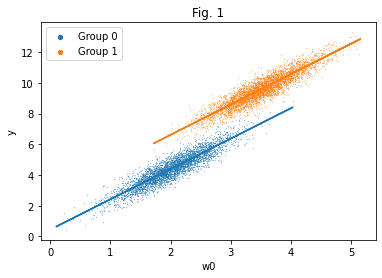

In [35]:
c0_grp = synth.loc[synth["c0"] == 1]
c1_grp = synth.loc[synth["c1"] == 1]

# Estimate fitted values from a linear regression model
c0_pred = LinearRegression().fit(c0_grp[["w0"]], c0_grp["y"]).predict(c0_grp[["w0"]])
c1_pred = LinearRegression().fit(c1_grp[["w0"]], c1_grp["y"]).predict(c1_grp[["w0"]])

# Scatter & line plot using Matplotlib
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(c0_grp["w0"], c0_pred)
plt.plot(c1_grp["w0"], c1_pred)
plt.title('Fig. 1')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

The scatterplot and linear regression fit lines in Fig. 1 revels a common (though very simplified) occurrence in many machine learning datasets: correlations between a given predictor variable `x` and the outcome variable `y` that are the product of a third variable `z`. In this case, the mean of group 0 is on average lower than group 1, such that predictions on `w0`... {Cullen?}. For example, `w0` could represent years of schooling, with `y` being the economic returns to education. In this example, the returns of both groups are the same...

### Remedy 1: The naive approach
#### Exclude all protected class feature(s) from the model

In [43]:
# Train a Tensorflow Keras deep learning model
model = keras_model()
model.fit(synth[['w0']], synth['y'], epochs=60, batch_size=128, verbose=0)
pred = model.predict(synth[['w0']]) # Generate prediction from model

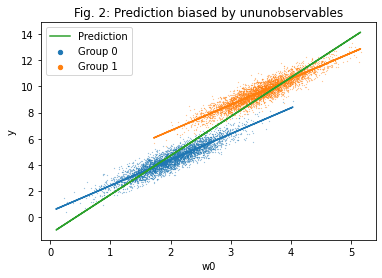

In [44]:
# Scatter & line plot using Matplotlib
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(c0_grp["w0"], c0_pred)
plt.plot(c1_grp["w0"], c1_pred)
plt.plot(synth['w0'], pred, label='Prediction')
plt.title('Fig. 2: Prediction biased by ununobservables')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

*Cullen - we need to explain the above*

### Remedy 2: Include protected class feature(s) & hope for the best

In [46]:
model = keras_model()
model.fit(synth[['c0', 'c1', 'w0']], synth['y'], epochs=60, batch_size=128, verbose=0)
pred = pd.DataFrame(model.predict(synth[['c0', 'c1', 'w0']]))
pred = aggregate_data(pred)

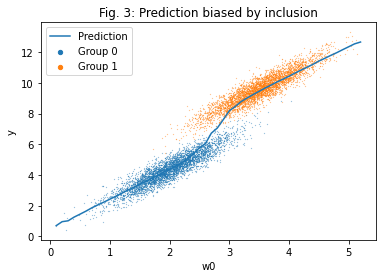

In [47]:
# Scatter & line plot using Matplotlib
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(pred, label='Prediction')
plt.title('Fig. 3: Prediction biased by inclusion')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

Cullen - let's explain this

# `DiscriminationMitigator`

To use DiscriminationMitigator users will need to specify two objects. First, a configuration JSON file (see example below). Second, a pre-trained LightGBM or Tensorflow Keras machine learning model.

### Basic setup

#### Specify a configuration file

In [9]:
with open('example_config.json') as j:
    config = json.load(j)
print("Example configuration dictionary: \n", config)

Example configuration dictionary: 
 {'protected_class_features': ['c0', 'c1']}


The config file requires users specify the protected class feature(s) as a list. Any features estimated in the model but not included in this list are assumed to be non-protected classe features.

#### Take a pre-trained LightGBM or Tensorflow Keras model (sequential/model)
*NOTE: PROTECTED CLASS FEATURE(S) MUST BE INCLUDED IN THE TRAINING MODEL!!*

In [48]:
# Note - we estimate the same model as directly above for clarity
model = keras_model()
model.fit(synth[['c0', 'c1', 'w0']], synth['y'], epochs=60, batch_size=128, verbose=0)

#### Instantiate `DiscriminationMitigator` class & call `predictions()` method

In [10]:
mitigated = DiscriminationMitigator(df=synth[['c0', 'c1', 'w0']], model=model, 
                              config=config).predictions()
print(mitigated.head())
print("\n", mitigated.describe())

   unadj_pred  unif_wts
0    4.965948  6.103953
1    7.616042  6.478035
2    5.211146  6.349152
3    9.074779  7.936771
4    3.607662  4.745668

         unadj_pred     unif_wts
count  8000.000000  8000.000000
mean      7.152867     7.157703
std       2.792188     1.770927
min       0.809666     1.947672
25%       4.527180     5.662278
50%       7.012392     7.135668
75%       9.776754     8.643230
max      13.026226    11.888220


The default specification returns a Pandas DataFrame with two features: `unadj_pred`, which is the unadjusted (biased) prediction, and `unif_wts`, which is the average of counterfactual predictions (i.e. uniform weights). This first column is equivalent to the prediction in Fig. 3 above.

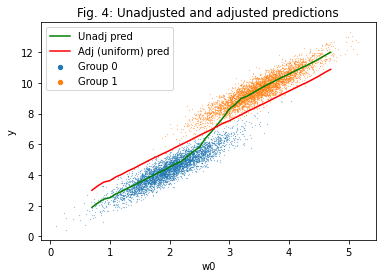

In [49]:
avg = aggregate_data(mitigated) # Average by rounded 'w0'
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(avg['unadj_pred'], label='Unadj pred', color='green')
plt.plot(avg['unif_wts'], label='Adj (uniform) pred', color='red')
plt.title('Fig. 4: Unadjusted and adjusted predictions')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

Cullen - let's explain this

### Option 1: Reweight predictions using the joint distributions of another dataset

In [12]:
# Split the data into train/val and test sets
X_train, X_test, y_train, y_test = train_test_split(synth.loc[:, ['c0', 'c1', 'w0']],
                                                    synth['y'], random_state=1776,
                                                    test_size=0.2)
# Train / val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=123, 
                                                  test_size=0.2)

for x in X_train, X_val, X_test:
    print(x.shape)

(5120, 3)
(1280, 3)
(1600, 3)


In [13]:
# Reestimate the model
model = keras_model()
model.fit(X_train, y_train, epochs=60, batch_size=128, validation_data=(X_val, y_val), verbose=0)

In [50]:
mitigated = DiscriminationMitigator(df=X_test, model=model, 
                              config=config, train=X_train).predictions()

print(mitigated.head())
print("\n", mitigated.describe())

      unadj_pred  unif_wts   pop_wts
6899    9.300457  8.209246  8.199015
163    10.068705  8.977491  8.967261
4780    9.512283  8.421070  8.410840
1891    5.352747  6.443960  6.433730
5372    7.704477  6.613264  6.603034

         unadj_pred     unif_wts      pop_wts
count  1600.000000  1600.000000  1600.000000
mean      6.820781     6.853518     6.843287
std       2.736207     1.753759     1.753759
min       1.272716     2.363929     2.353698
25%       4.239835     5.331048     5.320818
50%       6.147470     6.758134     6.747903
75%       9.455298     8.364086     8.353856
max      12.591762    11.500548    11.490318


Optionally, `DiscriminationMitigator` allows users to reweight predictions to reflect the joint distributions of the protected class feature(s) in another dataset. This may be advantageous, for example, if your test set is considerably smaller than your training set. In this case, `unif_wts` reflects the joint distributions of `df` (i.e. uniform weights; the default), while `pop_wts` reflects the joint distributions of `train`.

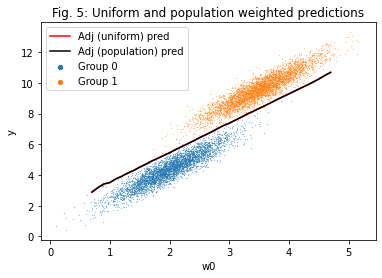

In [57]:
avg = aggregate_data(mitigated) # Average by rounded 'w0'
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(avg['unif_wts'], label='Adj (uniform) pred', color='red')
plt.plot(avg['pop_wts'], label='Adj (population) pred', color='black')
plt.title('Fig. 5: Uniform and population weighted predictions')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

### Option 2: Custom reweighting of select feature marginal distributions

In [52]:
with open('example_weights.json') as j:
    weights = json.load(j)
print(weights)

{'c0': {'1': 0.9, '0': 0.1}, 'c1': {'1': 0.1, '0': 0.9}}


You may also want to reweight predictions to ask 'what-if' questions: i.e. what if the share of group *x* were different than their observed share in the data? Providing a dictionary of custom marginal distributions to `weights` will allow for this. Importantly, feature marginals must sum to 1.0, otherwise this will produce a ValueError. At present it is only possible to reweight the marginal distributions of select features, not their joint distributions.

In [53]:
mitigated = DiscriminationMitigator(df=X_test, model=model, 
                              config=config, train=X_train, weights=weights).predictions()
print(mitigated.head())
print("\n", mitigated.describe())

      unadj_pred  unif_wts   pop_wts  cust_wts
6899    9.300457  8.209246  8.199015  7.336276
163    10.068705  8.977491  8.967261  8.104522
4780    9.512283  8.421070  8.410840  7.548099
1891    5.352747  6.443960  6.433730  5.570990
5372    7.704477  6.613264  6.603034  5.740294

         unadj_pred     unif_wts      pop_wts     cust_wts
count  1600.000000  1600.000000  1600.000000  1600.000000
mean      6.820781     6.853518     6.843287     5.980547
std       2.736207     1.753759     1.753759     1.753759
min       1.272716     2.363929     2.353698     1.490958
25%       4.239835     5.331048     5.320818     4.458078
50%       6.147470     6.758134     6.747903     5.885164
75%       9.455298     8.364086     8.353856     7.491116
max      12.591762    11.500548    11.490318    10.627578



Warning! The following features are extremely correlated and thus may be one-hot vectors: c0 c1. 
If no category is omitted, users must ensure custom marginal weights for one-hot vectors align correctly.


Moreover, in the presence of custom weights, `DiscriminationMitigator` raises a warning if any features appear extremely correlated, suggesting they may be recripocal one-hot vectors and that custom weights should therefore reflect mutual exclusivity in the underlying data. In our case, the joint distributions protected class features `c0` and `c1` are polar opposites, meaning we need to reweight *both* of these features. `DiscriminationMitigator`, however, does not enforce that custom weights of adjacent one-hot vectors are in fact reciprocals. 

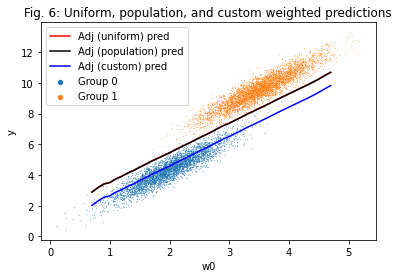

In [56]:
avg = aggregate_data(mitigated) # Average by rounded 'w0'
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(avg['unif_wts'], label='Adj (uniform) pred', color='red')
plt.plot(avg['pop_wts'], label='Adj (population) pred', color='black')
plt.plot(avg['cust_wts'], label='Adj (custom) pred', color='blue')
plt.title('Fig. 6: Uniform, population, and custom weighted predictions')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()